### Capstone - Initial Models
### Lawrence Huang
##### Instructions
Create a new notebook for this assignment.

1. Split prepared data from Milestone 1 into training and testing
2. Build a decision tree model that detects faulty products
3. Build an ensemble model that detects faulty products
4. Build an SVM model
5. Evaluate all three models
6. Describe your findings

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

##### Data prepration 

In [2]:
# load data: SECOM manufacturing Data Set from UCI Machine Learning Repository
filename_features = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
df = pd.read_csv(filename_features, header=None, sep=' ')
filename_label = 'http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df_label = pd.read_csv(filename_label, header=None, sep= ' ', usecols=[0]) # don't need label timestamp

# merge data: add label to features
df['label'] = df_label

# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(1567, 591)


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [3]:
# identify zero variance columns with constant/single value 
cols_zero_var = df.loc[:, df.nunique()==1].columns.values
print('Columns with single value:\n{}'.format(cols_zero_var))
print('\n# columns with single value: {}'.format(len(cols_zero_var)))
# drop zero variance columns with constant/single value 
df.drop(cols_zero_var, axis=1, inplace=True)

Columns with single value:
[5 13 42 49 52 69 97 141 149 178 179 186 189 190 191 192 193 194 226 229
 230 231 232 233 234 235 236 237 240 241 242 243 256 257 258 259 260 261
 262 263 264 265 266 276 284 313 314 315 322 325 326 327 328 329 330 364
 369 370 371 372 373 374 375 378 379 380 381 394 395 396 397 398 399 400
 401 402 403 404 414 422 449 450 451 458 461 462 463 464 465 466 481 498
 501 502 503 504 505 506 507 508 509 512 513 514 515 528 529 530 531 532
 533 534 535 536 537 538]

# columns with single value: 116


In [4]:
# handle null/missing values
# examine data type: all numeric
print('data type:')
print(df.dtypes.value_counts())

# number of missing values: some columns are missing > 90% of values
num_missing = df.isna().sum()
print('\n# missing values/ # of columns:')
print(num_missing.value_counts().sort_index())

data type:
float64    474
int64        1
dtype: int64

# missing values/ # of columns:
0       53
1       80
2       84
3       20
4        9
5        3
6       57
7       20
8       12
9       15
10       4
12       4
14      16
24      38
51       8
260     12
273      8
715      4
794      4
949      4
1018    12
1341     4
1429     4
dtype: int64


In [5]:
# drop columns missing >50%
cols_excess_missing = num_missing[num_missing>df.shape[0]/2].index.to_list()
print('\nColumns with >50% missing values:\n{}'.format(cols_excess_missing))
print('\n# columns with >50% missing values: {}'.format(len(cols_excess_missing)))
df.drop(cols_excess_missing, axis=1, inplace=True)


Columns with >50% missing values:
[72, 73, 85, 109, 110, 111, 157, 158, 220, 244, 245, 246, 292, 293, 345, 346, 358, 382, 383, 384, 492, 516, 517, 518, 578, 579, 580, 581]

# columns with >50% missing values: 28


In [6]:
# impute other columns with missing values
# strategy: fill with median or 0. Trying median here.
print('# missing values before imputation: {}'.format(df.isna().sum().sum()))
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# imputer = SimpleImputer(missing_values=np.nan, strategy='constant') # fill with 0
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
print('# missing values after imputation: {}'.format(df.isna().sum().sum()))

# missing values before imputation: 10868
# missing values after imputation: 0


In [7]:
# find columns with near-zero variance, with conditions 1 and 2:
# 1. few (<10%) unique values relative to the number of samples 
# 2. large ratio (>19, or >95:5%) of the frequency of the most common value to the frequency of the second most common value
top2 = (df.apply(lambda x: pd.Series(x.value_counts().values[:2]))).T
cols_nzv = df.columns[(df.nunique()/df.shape[0]<0.1) & (top2[0]/top2[1]>19)].to_list()
print('columns with near-zero variance:\n{}'.format(cols_nzv))
print('\n# columns with near-zero variance: {}'.format(len(cols_nzv)))
# drop columns with near-zero variance
df.drop(cols_nzv, axis=1, inplace=True)

columns with near-zero variance:
[74, 114, 206, 209, 249, 342, 347, 387, 478, 521, 542]

# columns with near-zero variance: 11


In [8]:
# view cleaned and preprocessed dataframe
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(1567, 436)


,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.0205,0.0148,0.0046,71.9005,-1.0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1.0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1.0
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1.0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1.0


##### 1. Split prepared data from Milestone 1 into training and testing

In [9]:
# train/test split
# stratify to ensure minority class representation in both sets
y = df['label'] # label
X = df.loc[:, ~df.columns.isin(['label'])] # features, start with all but the target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=8)
print('features:\n{}'.format(X.columns.values))
print('\n# features at start: {}'.format(len(X.columns.values)))

features:
[0 1 2 3 4 6 7 8 9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47 48 50 51 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 70 71 75 76 77 78 79 80 81 82 83
 84 86 87 88 89 90 91 92 93 94 95 96 98 99 100 101 102 103 104 105 106 107
 108 112 113 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 150 151 152 153 154 155 156 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 180 181 182 183 184 185 187 188 195 196
 197 198 199 200 201 202 203 204 205 207 208 210 211 212 213 214 215 216
 217 218 219 221 222 223 224 225 227 228 238 239 247 248 250 251 252 253
 254 255 267 268 269 270 271 272 273 274 275 277 278 279 280 281 282 283
 285 286 287 288 289 290 291 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 316 317 318 319 320 321 323 324 331 332
 333 334 335 336 337 338 339 340 341 34

In [10]:
# standardize numeric columns (z-score)
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

##### Handle class imbalance problem

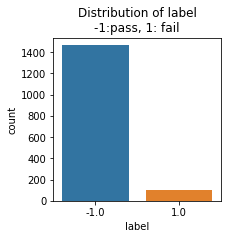

fail rate: 6.6%


In [11]:
# plot distribution of label; check for imbalanced classes
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x='label', data=df, ax=ax)
plt.title('Distribution of label\n-1:pass, 1: fail')
plt.show()
print('fail rate: {:.1f}%'.format(100*df['label'].value_counts()[1]/len(df['label'])))

In [12]:
# SMOTE was used to oversample the minority class
# By oversampling only on the training data, none of the information in the test data was being used to create synthetic observations. 
# Therefore, no information will bleed from training to testing.  
sm = SMOTE(random_state=1) # sampling strategy = resample all classes but the majority class
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(data=X_train_res, columns=X_train.columns)
y_train_res = pd.Series(y_train_res)

print('\nLabel counts before SMOTE:')
print(y_train.value_counts())
print('\nLabel counts after SMOTE:')
print(y_train_res.value_counts())


Label counts before SMOTE:
-1.0    1170
 1.0      83
Name: label, dtype: int64

Label counts after SMOTE:
 1.0    1170
-1.0    1170
dtype: int64


##### Apply feature selection techniques to reduce dimensionality of data
Use filtering methods based on Mutual information score or ANOVA F-value between label/feature to compare the same set of selected features across multiple classifiers

##### Select k best features based on mutual information score (k=20)

In [13]:
# select k best features based on mutual information score
selector = SelectKBest(score_func=mutual_info_classif, k=20).fit(X_train_res, y_train_res) 
# selected features
mi_cols = X_train_res.columns[selector.get_support()].to_list()
print('selected features:\n{}'.format(mi_cols))
print('\n# selected features: {}'.format(len(mi_cols)))
X_train_mi = pd.DataFrame(selector.transform(X_train_res), columns=mi_cols)
X_test_mi = pd.DataFrame(selector.transform(X_test), columns=mi_cols)

selected features:
[104, 121, 123, 124, 131, 143, 155, 166, 167, 219, 238, 239, 278, 288, 357, 366, 368, 376, 377, 584]

# selected features: 20


##### Select k best features based on ANOVA F-value (k=20)

In [14]:
# select k best features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=20).fit(X_train_res, y_train_res) 
# selected features
f_cols = X_train_res.columns[selector.get_support()].to_list()
print('Selected features:\n{}'.format(f_cols))
print('\n# selected features: {}'.format(len(f_cols)))
X_train_f = pd.DataFrame(selector.transform(X_train_res), columns=f_cols)
X_test_f = pd.DataFrame(selector.transform(X_test), columns=f_cols)

Selected features:
[14, 28, 59, 70, 78, 79, 103, 121, 122, 124, 125, 127, 129, 130, 183, 247, 280, 319, 455, 510]

# selected features: 20


##### 2. Build a decision tree model that detects faulty products<a name="DT"></a>

##### Default decision tree, no additional feature selection

In [15]:
# default gini tree
clf_tree = DecisionTreeClassifier(random_state=8)
clf_tree.fit(X_train_res, y_train_res)
print('# features: {}'.format(X_train_res.shape[1]))
cv_scores = cross_val_score(clf_tree, X_train_res, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_tree = clf_tree.predict(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_tree)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_tree))

# tree depth and # leaves
print('\nTree depth: {}, # leaves: {}'.format(clf_tree.get_depth(), clf_tree.get_n_leaves()))

# features: 435
Mean CV recall (Class 1): 0.946

Confusion Matrix:
[[269  24]
 [ 13   8]]

TP, TN, FP, FN: 8 , 269 , 24 , 13

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.92      0.94       293
         1.0       0.25      0.38      0.30        21

    accuracy                           0.88       314
   macro avg       0.60      0.65      0.62       314
weighted avg       0.91      0.88      0.89       314


Tree depth: 29, # leaves: 87


##### Default decision tree, 20 selected features by mutual information score

In [16]:
# default gini tree
clf_tree = DecisionTreeClassifier(random_state=8)
clf_tree.fit(X_train_mi, y_train_res)
print('# features: {}'.format(X_train_mi.shape[1]))
cv_scores = cross_val_score(clf_tree, X_train_mi, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_tree = clf_tree.predict(X_test_mi)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_tree)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_tree))

# tree depth and # leaves
print('\nTree depth: {}, # leaves: {}'.format(clf_tree.get_depth(), clf_tree.get_n_leaves()))

# features: 20
Mean CV recall (Class 1): 0.870

Confusion Matrix:
[[245  48]
 [ 17   4]]

TP, TN, FP, FN: 4 , 245 , 48 , 17

Classification report:
              precision    recall  f1-score   support

        -1.0       0.94      0.84      0.88       293
         1.0       0.08      0.19      0.11        21

    accuracy                           0.79       314
   macro avg       0.51      0.51      0.50       314
weighted avg       0.88      0.79      0.83       314


Tree depth: 25, # leaves: 204


##### Default decision tree, 20 selected features by ANOVA F-value

In [17]:
# default gini tree
clf_tree = DecisionTreeClassifier(random_state=8)
clf_tree.fit(X_train_f, y_train_res)
print('# features: {}'.format(X_train_f.shape[1]))
cv_scores = cross_val_score(clf_tree, X_train_f, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_tree = clf_tree.predict(X_test_f)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_tree)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_tree))

# tree depth and # leaves
print('\nTree depth: {}, # leaves: {}'.format(clf_tree.get_depth(), clf_tree.get_n_leaves()))

# features: 20
Mean CV recall (Class 1): 0.921

Confusion Matrix:
[[260  33]
 [ 14   7]]

TP, TN, FP, FN: 7 , 260 , 33 , 14

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.89      0.92       293
         1.0       0.17      0.33      0.23        21

    accuracy                           0.85       314
   macro avg       0.56      0.61      0.57       314
weighted avg       0.90      0.85      0.87       314


Tree depth: 29, # leaves: 175


###### Preliminary results:
The default decision tree with no additional feature selection or model using 20 selected features by ANOVA F-value produced better results, as assessed by recall of Class 1 on the test set, compared to the model using 20 selected features by Mutual Information score.

Will try tuning the best 2 models (1: no additional feature selection and 2: 20 selected features by ANOVA F-value) to see if recall of Class 1 could be improved.

##### Tuned decision tree, no additional feature selection

In [18]:
# decision tree with tuned hyperparameters
# grid search parameters
parameters = [{#'criterion': ['gini', 'entropy'], # use gini
               'max_leaf_nodes': range(20, 201, 20),
               'max_depth': range(8, 33, 4),
               'min_samples_leaf': range(1,7),
               'min_samples_split' : range(2,6)
              }]
print('The following hyperparameters were tuned:\n{}'.format(list(parameters[0].keys())))

The following hyperparameters were tuned:
['max_leaf_nodes', 'max_depth', 'min_samples_leaf', 'min_samples_split']


In [19]:
# grid search, fit and predict with best estimator
gs_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=8), 
                       param_grid=parameters, iid=False, cv=3, scoring='recall', n_jobs=-1, verbose=1)
gs_tree.fit(X_train_res, y_train_res)
y_pred_gstree = gs_tree.predict(X_test)

Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5040 out of 5040 | elapsed:  8.0min finished


In [20]:
print('# features: {}'.format(X_train_res.shape[1]))

# best tuned decision tree and hyperparameters
print('\nBest hyperparameters:\n{}'.format(gs_tree.best_params_))
print('\nBest tuned estimator:\n{}'.format(gs_tree.best_estimator_))
print('\nBest mean CV score: {:.3f}'.format(gs_tree.best_score_))
print('\nFeatures with non-zero importance: {}'.format((gs_tree.best_estimator_.feature_importances_!=0).sum()))

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gstree)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gstree).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gstree))

# tree depth and # leaves
print('\nTuned tree depth: {}, # leaves: {}'.format(gs_tree.best_estimator_.get_depth(), gs_tree.best_estimator_.get_n_leaves()))

# features: 435

Best hyperparameters:
{'max_depth': 8, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best tuned estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=60,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=8, splitter='best')

Best mean CV score: 0.952

Features with non-zero importance: 42

Confusion Matrix:
[[243  50]
 [ 12   9]]

TP, TN, FP, FN: 9 , 243 , 50 , 12

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.83      0.89       293
         1.0       0.15      0.43      0.23        21

    accuracy                           0.80       314
   macro avg       0.55      0.63      0.56       314
weighted avg    

##### Tuned decision tree, 20 selected features by ANOVA F-value

In [21]:
# decision tree with tuned hyperparameters
# grid search parameters
parameters = [{#'criterion': ['gini', 'entropy'], # use gini
               'max_leaf_nodes': range(20, 201, 20),
               'max_depth': range(8, 33, 4),
               'min_samples_leaf': range(1,7),
               'min_samples_split' : range(2,6)
              }]
print('The following hyperparameters were tuned:\n{}'.format(list(parameters[0].keys())))

The following hyperparameters were tuned:
['max_leaf_nodes', 'max_depth', 'min_samples_leaf', 'min_samples_split']


In [22]:
# grid search, fit and predict with best estimator
gs_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=8), 
                       param_grid=parameters, iid=False, cv=3, scoring='recall', n_jobs=-1, verbose=1)
gs_tree.fit(X_train_f, y_train_res)
y_pred_gstree = gs_tree.predict(X_test_f)

Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1696 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4196 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 5040 out of 5040 | elapsed:   22.8s finished


In [23]:
print('# features: {}'.format(X_train_f.shape[1]))

# best tuned decision tree and hyperparameters
print('\nBest hyperparameters:\n{}'.format(gs_tree.best_params_))
print('\nBest tuned estimator:\n{}'.format(gs_tree.best_estimator_))
print('\nBest mean CV score: {:.3f}'.format(gs_tree.best_score_))
print('\nFeatures with non-zero importance: {}'.format((gs_tree.best_estimator_.feature_importances_!=0).sum()))

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gstree)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gstree).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gstree))

# tree depth and # leaves
print('\nTuned tree depth: {}, # leaves: {}'.format(gs_tree.best_estimator_.get_depth(), gs_tree.best_estimator_.get_n_leaves()))

# features: 20

Best hyperparameters:
{'max_depth': 12, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 4}

Best tuned estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
                       max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=8, splitter='best')

Best mean CV score: 0.927

Features with non-zero importance: 19

Confusion Matrix:
[[242  51]
 [ 13   8]]

TP, TN, FP, FN: 8 , 242 , 51 , 13

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.83      0.88       293
         1.0       0.14      0.38      0.20        21

    accuracy                           0.80       314
   macro avg       0.54      0.60      0.54       314
weighted avg 

In [24]:
# use the above (tuned decision tree with feature selection using ANOVA F-value) for comparison across models
precision_t, recall_t, fscore_t, support_t = precision_recall_fscore_support(y_test, y_pred_gstree)
accuracy_t = accuracy_score(y_test, y_pred_gstree)

##### Summary for decision tree model:
<ul>
    <li>The default decision tree model with no additional feature selection produced the best Class 1 recall (and also the best overall accuracy), compared to 20-feature subsets selected by Mutual Information score or ANOVA F-value</li>
    <li>After hyperparameter tuning, recall for Class 1 improved slightly in both the model with no additional feature selection and the model with feature selection by ANOVA F-value</li>
    <li>After hyperparameter tuning, the model with feature selection by ANOVA F-value produced very similar results compared to the model with no additional feature selection, despite using ~45% of the features for splitting: 19 (out of 20) compared to 42 (out of 435) features with non-zero importance, respectively</li>
    </ul>

##### 3. Build an ensemble model that detects faulty products<a name="RF"></a>
Will construct a random forest model

##### Default random forest, no additional feature selection

In [25]:
# random forest
rf = RandomForestClassifier(n_estimators=40, random_state=8) # where 40 ~= sqrt of # observations
rf.fit(X_train_res, y_train_res)
print('# features: {}'.format(X_train_res.shape[1]))
cv_scores = cross_val_score(rf, X_train_res, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_rf = rf.predict(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_rf))

# features: 435
Mean CV recall (Class 1): 0.985

Confusion Matrix:
[[290   3]
 [ 19   2]]

TP, TN, FP, FN: 2 , 290 , 3 , 19

Classification report:
              precision    recall  f1-score   support

        -1.0       0.94      0.99      0.96       293
         1.0       0.40      0.10      0.15        21

    accuracy                           0.93       314
   macro avg       0.67      0.54      0.56       314
weighted avg       0.90      0.93      0.91       314



##### Try again using hyperparameters from the decision tree model above (that had the same feature set)

In [26]:
# random forest, using tuned decision tree hyperparameters above for no additional feature selection
rf = RandomForestClassifier(n_estimators=40, random_state=8, # where 40 ~= sqrt of # observations
                           max_depth=8, max_leaf_nodes=60, min_samples_leaf=1, min_samples_split=2) 
rf.fit(X_train_res, y_train_res)
print('# features: {}'.format(X_train_res.shape[1]))
cv_scores = cross_val_score(rf, X_train_res, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_rf = rf.predict(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_rf))

# features: 435
Mean CV recall (Class 1): 0.985

Confusion Matrix:
[[276  17]
 [ 18   3]]

TP, TN, FP, FN: 3 , 276 , 17 , 18

Classification report:
              precision    recall  f1-score   support

        -1.0       0.94      0.94      0.94       293
         1.0       0.15      0.14      0.15        21

    accuracy                           0.89       314
   macro avg       0.54      0.54      0.54       314
weighted avg       0.89      0.89      0.89       314



##### Default random forest, 20 features by mutual information score

In [27]:
# random forest
rf = RandomForestClassifier(n_estimators=40, random_state=8) # where 40 ~= sqrt of # observations
rf.fit(X_train_mi, y_train_res)
print('# features: {}'.format(X_train_mi.shape[1]))
cv_scores = cross_val_score(rf, X_train_mi, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_rf = rf.predict(X_test_mi)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_rf))

# features: 20
Mean CV recall (Class 1): 0.938

Confusion Matrix:
[[284   9]
 [ 20   1]]

TP, TN, FP, FN: 1 , 284 , 9 , 20

Classification report:
              precision    recall  f1-score   support

        -1.0       0.93      0.97      0.95       293
         1.0       0.10      0.05      0.06        21

    accuracy                           0.91       314
   macro avg       0.52      0.51      0.51       314
weighted avg       0.88      0.91      0.89       314



##### Default random forest, 20 features by ANOVA F-value

In [28]:
# random forest
rf = RandomForestClassifier(n_estimators=40, random_state=8) # where 40 ~= sqrt of # observations
rf.fit(X_train_f, y_train_res)
print('# features: {}'.format(X_train_f.shape[1]))
cv_scores = cross_val_score(rf, X_train_f, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_rf = rf.predict(X_test_f)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_rf))

# features: 20
Mean CV recall (Class 1): 0.962

Confusion Matrix:
[[277  16]
 [ 16   5]]

TP, TN, FP, FN: 5 , 277 , 16 , 16

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.95      0.95       293
         1.0       0.24      0.24      0.24        21

    accuracy                           0.90       314
   macro avg       0.59      0.59      0.59       314
weighted avg       0.90      0.90      0.90       314



##### Try again using hyperparameters from the decision tree model above (that had the same feature set)

In [29]:
# random forest, using tuned decision tree hyperparameters above for feature selection using ANOVA F-value
rf = RandomForestClassifier(n_estimators=40, random_state=8, # where 40 ~= sqrt of # observations
                           max_depth=12, max_leaf_nodes=100, min_samples_leaf=1, min_samples_split=4) 
rf.fit(X_train_f, y_train_res)
print('# features: {}'.format(X_train_f.shape[1]))
cv_scores = cross_val_score(rf, X_train_f, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_rf = rf.predict(X_test_f)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_rf))

# features: 20
Mean CV recall (Class 1): 0.960

Confusion Matrix:
[[272  21]
 [ 16   5]]

TP, TN, FP, FN: 5 , 272 , 21 , 16

Classification report:
              precision    recall  f1-score   support

        -1.0       0.94      0.93      0.94       293
         1.0       0.19      0.24      0.21        21

    accuracy                           0.88       314
   macro avg       0.57      0.58      0.57       314
weighted avg       0.89      0.88      0.89       314



##### Preliminary results:
The random forest model with 20 features by ANOVA F-value produced the best results, as assessed by the recall of Class 1 on the test set. By this metric, the other random forest models (with no additional feature selection and feature selection using Mutual Information score) performed worse than the decision tree models.

Will try tuning the best random forest model (with 20 features by ANOVA F-value) to see if recall of Class 1 could be improved.

##### Tuned random forest, 20 features by ANOVA F-value

In [30]:
# grid search parameters
# use gini trees
parameters = [{'n_estimators': [20, 40, 100, 200], # where 40 ~= sqrt of # observations
               'max_leaf_nodes': range(20, 201, 20),
               'max_depth': range(8, 33, 4),
               'min_samples_leaf': range(1,6),
               'min_samples_split' : range(2,6)
              }]
print('The following hyperparameters were tuned:\n{}'.format(list(parameters[0].keys())))

The following hyperparameters were tuned:
['n_estimators', 'max_leaf_nodes', 'max_depth', 'min_samples_leaf', 'min_samples_split']


In [31]:
# grid search, fit with best estimator
gs_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=8), 
                     param_grid=parameters, iid=False, cv=3, scoring='recall', n_jobs=-1, verbose=1)
gs_rf.fit(X_train_f, y_train_res)
y_pred_gsrf = gs_rf.predict(X_test_f)

Fitting 3 folds for each of 5600 candidates, totalling 16800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 910 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 1610 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2510 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3578 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4228 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4978 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 6778 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 7828 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 8978 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 10228 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 11578 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 13028 tasks    

In [32]:
print('# features: {}'.format(X_train_f.shape[1]))

# best tuned decision random forest hyperparameters
print('\nBest hyperparameters:\n{}'.format(gs_rf.best_params_))
print('\nBest tuned estimator:\n{}'.format(gs_rf.best_estimator_))
print('\nBest mean CV score: {:.3f}'.format(gs_rf.best_score_))

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gsrf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gsrf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gsrf))

# features: 20

Best hyperparameters:
{'max_depth': 16, 'max_leaf_nodes': 120, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best tuned estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=120,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

Best mean CV score: 0.970

Confusion Matrix:
[[275  18]
 [ 14   7]]

TP, TN, FP, FN: 7 , 275 , 18 , 14

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.94      0.95       293
         1.0       0.28      0.33      0.30        21

    accuracy                           0.90       314

In [33]:
# use the above (tuned random forest with feature selection using ANOVA F-value) for comparison across models
precision_r, recall_r, fscore_r, support_r = precision_recall_fscore_support(y_test, y_pred_gsrf)
accuracy_r = accuracy_score(y_test, y_pred_gsrf)

##### Summary for random forest model:
<ul>
    <li>The random forest model with feature selection using ANOVA F-value produced the best results, as assessed by recall of Class 1 on the test set; hyperparameter tuning further improved recall</li>
    <li>The other random forest models (with no additional feature selection and feature selection using Mutual Information score) performed worse than the decision tree models, as assessed by recall of Class 1 on test set, possibly due to imbalanced classes in the test set (SMOTE was applied only to the training data)</li>
    </ul>

##### 4. Build an SVM model<a name="SVM"></a>

##### Default SVM (SVC), no additional feature selection 

In [34]:
# default SVC
svc = SVC(gamma='auto', random_state=8)
svc.fit(X_train_res, y_train_res)
print('# features: {}'.format(X_train_res.shape[1]))
cv_scores = cross_val_score(svc, X_train_res, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_svc = svc.predict(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_svc)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svc).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_svc))

# features: 435
Mean CV recall (Class 1): 0.997

Confusion Matrix:
[[290   3]
 [ 21   0]]

TP, TN, FP, FN: 0 , 290 , 3 , 21

Classification report:
              precision    recall  f1-score   support

        -1.0       0.93      0.99      0.96       293
         1.0       0.00      0.00      0.00        21

    accuracy                           0.92       314
   macro avg       0.47      0.49      0.48       314
weighted avg       0.87      0.92      0.90       314



##### Default SVM (SVC), 20 features by mutual information score

In [35]:
# default SVC
svc = SVC(gamma='auto', random_state=8)
svc.fit(X_train_mi, y_train_res)
print('# features: {}'.format(X_train_mi.shape[1]))
cv_scores = cross_val_score(svc, X_train_mi, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_svc = svc.predict(X_test_mi)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_svc)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svc).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_svc))

# features: 20
Mean CV recall (Class 1): 0.897

Confusion Matrix:
[[233  60]
 [ 17   4]]

TP, TN, FP, FN: 4 , 233 , 60 , 17

Classification report:
              precision    recall  f1-score   support

        -1.0       0.93      0.80      0.86       293
         1.0       0.06      0.19      0.09        21

    accuracy                           0.75       314
   macro avg       0.50      0.49      0.48       314
weighted avg       0.87      0.75      0.81       314



##### Default SVM (SVC), 20 features by ANOVA F-value

In [36]:
# default SVC
svc = SVC(gamma='auto', random_state=8)
svc.fit(X_train_f, y_train_res)
cv_scores = cross_val_score(svc, X_train_f, y_train_res, cv=3, scoring='recall')
print('Mean CV recall (Class 1): {:.3f}'.format(cv_scores.mean()))

# prediction
y_pred_svc = svc.predict(X_test_f)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_svc)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svc).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_svc))

Mean CV recall (Class 1): 0.947

Confusion Matrix:
[[250  43]
 [ 14   7]]

TP, TN, FP, FN: 7 , 250 , 43 , 14

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.85      0.90       293
         1.0       0.14      0.33      0.20        21

    accuracy                           0.82       314
   macro avg       0.54      0.59      0.55       314
weighted avg       0.89      0.82      0.85       314



##### Preliminary results:
Using the default SVM (SVC) with feature selection using ANOVA F-value produced the best result, as assessed by the recall of Class 1 on the test set. Using all features did not work (no true positives).

Will try tuning the SVC using feature selection by ANOVA F-value to see if recall of Class 1 could be improved.

##### Tuned SVM (SVC), 20 features by ANOVA F-value

In [37]:
# grid search parameters
parameters = [
    {'C': [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 'kernel': ['rbf', 'sigmoid'], 'gamma': [0.005, 'auto', 0.5, 1, 'scale']},
#     {'C': [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 'kernel': ['poly'], 'gamma': [0.005, 'auto', 0.5, 1, 'scale'], 'degree': [2,3,4]},
    {'C': [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 'kernel': ['linear']}
]
print('The following hyperparameters were tuned:\n{}'.format(list(parameters[0].keys())))

The following hyperparameters were tuned:
['C', 'kernel', 'gamma']


#### Note:
From the first run, the best hyperparameters were: {'C': 0.1, 'degree': 2, 'gamma': 0.005, 'kernel': 'poly'}. However, this model identified all observations as Class 1 and was not useful (while recall of Class 1 was 1, there were 0 true negatives; all false positives). The grid search was re-ran without kernel=poly.

In [38]:
# grid search, fit with best estimator
gs_svc = GridSearchCV(estimator=SVC(random_state=8), param_grid=parameters, iid=False, cv=3, scoring='recall', n_jobs=-1, verbose=1)
gs_svc.fit(X_train_f, y_train_res)
y_pred_gssvc = gs_svc.predict(X_test_f)

Fitting 3 folds for each of 66 candidates, totalling 198 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed: 10.7min finished


In [39]:
print('# features: {}'.format(X_train_f.shape[1]))

# best tuned estimator and hyperparameters
print('\nBest hyperparameters: {}'.format(gs_svc.best_params_))
print('\nBest tuned estimator:\n{}'.format(gs_svc.best_estimator_))
print('\nBest mean CV score: {:.3f}'.format(gs_svc.best_score_))

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gssvc)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gssvc).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gssvc))

# features: 20

Best hyperparameters: {'C': 10000.0, 'gamma': 0.005, 'kernel': 'rbf'}

Best tuned estimator:
SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

Best mean CV score: 0.995

Confusion Matrix:
[[270  23]
 [ 16   5]]

TP, TN, FP, FN: 5 , 270 , 23 , 16

Classification report:
              precision    recall  f1-score   support

        -1.0       0.94      0.92      0.93       293
         1.0       0.18      0.24      0.20        21

    accuracy                           0.88       314
   macro avg       0.56      0.58      0.57       314
weighted avg       0.89      0.88      0.88       314



In [40]:
# use the above (tuned SVC with feature selection using ANOVA F-value) for comparison across models
precision_s, recall_s, fscore_s, support_s = precision_recall_fscore_support(y_test, y_pred_gssvc)
accuracy_s = accuracy_score(y_test, y_pred_gssvc)

##### Summary for SVM:
<ul>
    <li>SVC (default parameters) using all features did not work (no true positives)</li>
    <li>SVC (default parameters) and feature selection using ANOVA F-value produced the best result, as assessed by the recall of Class 1 on the test set</li>
    <li>However, after hyperparameter tuning recall of Class 1 on the test set did not improve (although overall accuracy did)</li>
    </ul>

##### 5. Evaluate all three models
Please see above sections for evaluation and summary of the decision tree, ensemble (random forest), and SVM models.<br>
All models were evaluated by confusion matrix-derived metrics, primarily by recall of Class 1 (to detect faulty products) and were tuned accordingly.<p>
[Evaluation of decision tree model](#DT)<br>
[Evaluation of ensemble model (random forest)](#RF)<br>
[Evaluation of SVM model](#SVM)


The table (dataframe) below compares results from tuned decision tree, random forest, and SVM models using the same feature set (20 features selected using ANOVA F-value)
<ul>
    <li>Based on Class 1 recall: decision tree > random forest > SVM</li>
    <li>Based on Class 1 f1-score: random forest > SVM > decision tree</li>
    </ul>

In [41]:
results = pd.DataFrame({'Decision Tree': np.round([precision_t[1], recall_t[1], fscore_t[1], accuracy_t],3),
              'Random Forest': np.around([precision_r[1], recall_r[1], fscore_r[1], accuracy_r],3),
              'SVM': np.round([precision_s[1], recall_s[1], fscore_s[1], accuracy_s],3)
             }, index=['Precision', 'Recall', 'f1-score', 'Overall accuracy'])
results.T

,Precision,Recall,f1-score,Overall accuracy
Decision Tree,0.136,0.381,0.200,0.796
Random Forest,0.280,0.333,0.304,0.898
SVM,0.179,0.238,0.204,0.876


##### 6. Describe your findings
##### Results summary:
<ul>
    <li>From Milestone 1, preprocessing was performed (435 features remained after preprocessing) and class imbalance was handled by applying SMOTE on the training set</li>
    <li>Filtering methods based on Mutual information score or ANOVA F-value between label/feature were used to reduce dimensionality of the data (20 features were selected using each scoring method)</li>
    <p><p>
    <li>Decision tree, ensemble (here, random forest), and SVM models were constructed to detect faulty products </li>
        <li>Generally, the 3 models worked best with 20 selected features by ANOVA F-value (as assessed by recall on Class 1 to detect faulty products</li>
        <li>After hyperparameter tuning, recall for Class 1 was slightly increased for the decision tree and random forest models but not the SVM</li><p>
        <li>Comparing the 3 model types:
            <ul>
                <li>Based on Class 1 recall: decision tree > random forest > SVM</li>
                <li>Based on Class 1 f1-score (taking into account precision): random forest > SVM > decision tree</li>
            </ul>
        </li>
        <li>None of the 3 models tested here produced a high recall for Class 1; the highest was ~40%. Additional models (e.g. different ensemble models, neural network) and dimensional reduction techniques (e.g. PCA, foward/backward selection) could be tested</li>
</ul>